Import potrzebnych bibliotek


In [77]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import sklearn
import sklearn.datasets
import sklearn.model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

Ładujemy dane i wyswietlamy je w tabelce z naglowkami (cechami)

In [24]:
data = pd.read_csv("../Datasets/breast-cancer.csv")
data = data.drop('id',axis=1)
data.info()
data.head(3)

# drop the id column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Wyświetlamy problem ktory chcemy rozpoznac ale liczymy ilosc danych

In [4]:
data["diagnosis"].unique()
data["diagnosis"].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

Spróbujmy wziąć pod uwagę tylko te cechy, które mają największe korelacje z diagnozą.

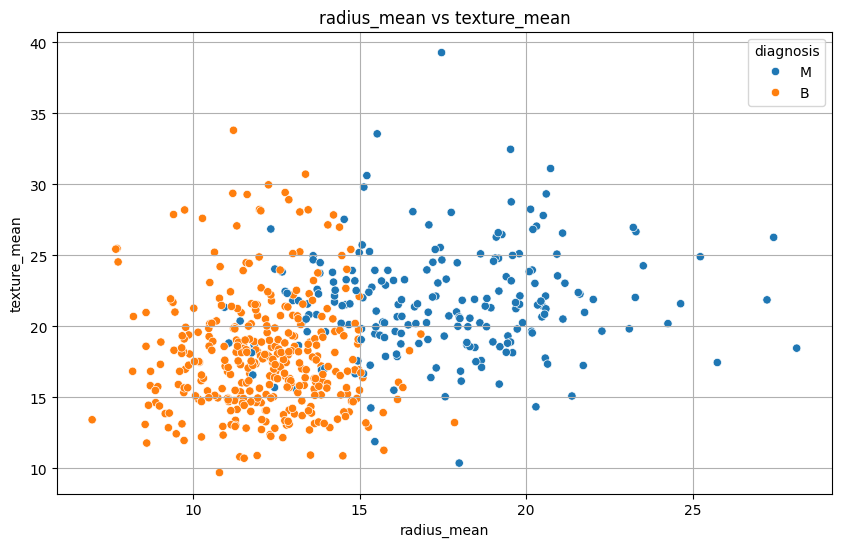

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='radius_mean',y='texture_mean',data=data,hue='diagnosis')
plt.title('radius_mean vs texture_mean')
plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.grid(True)
plt.show()


Zobaczmy jak wyglada rozklad probek

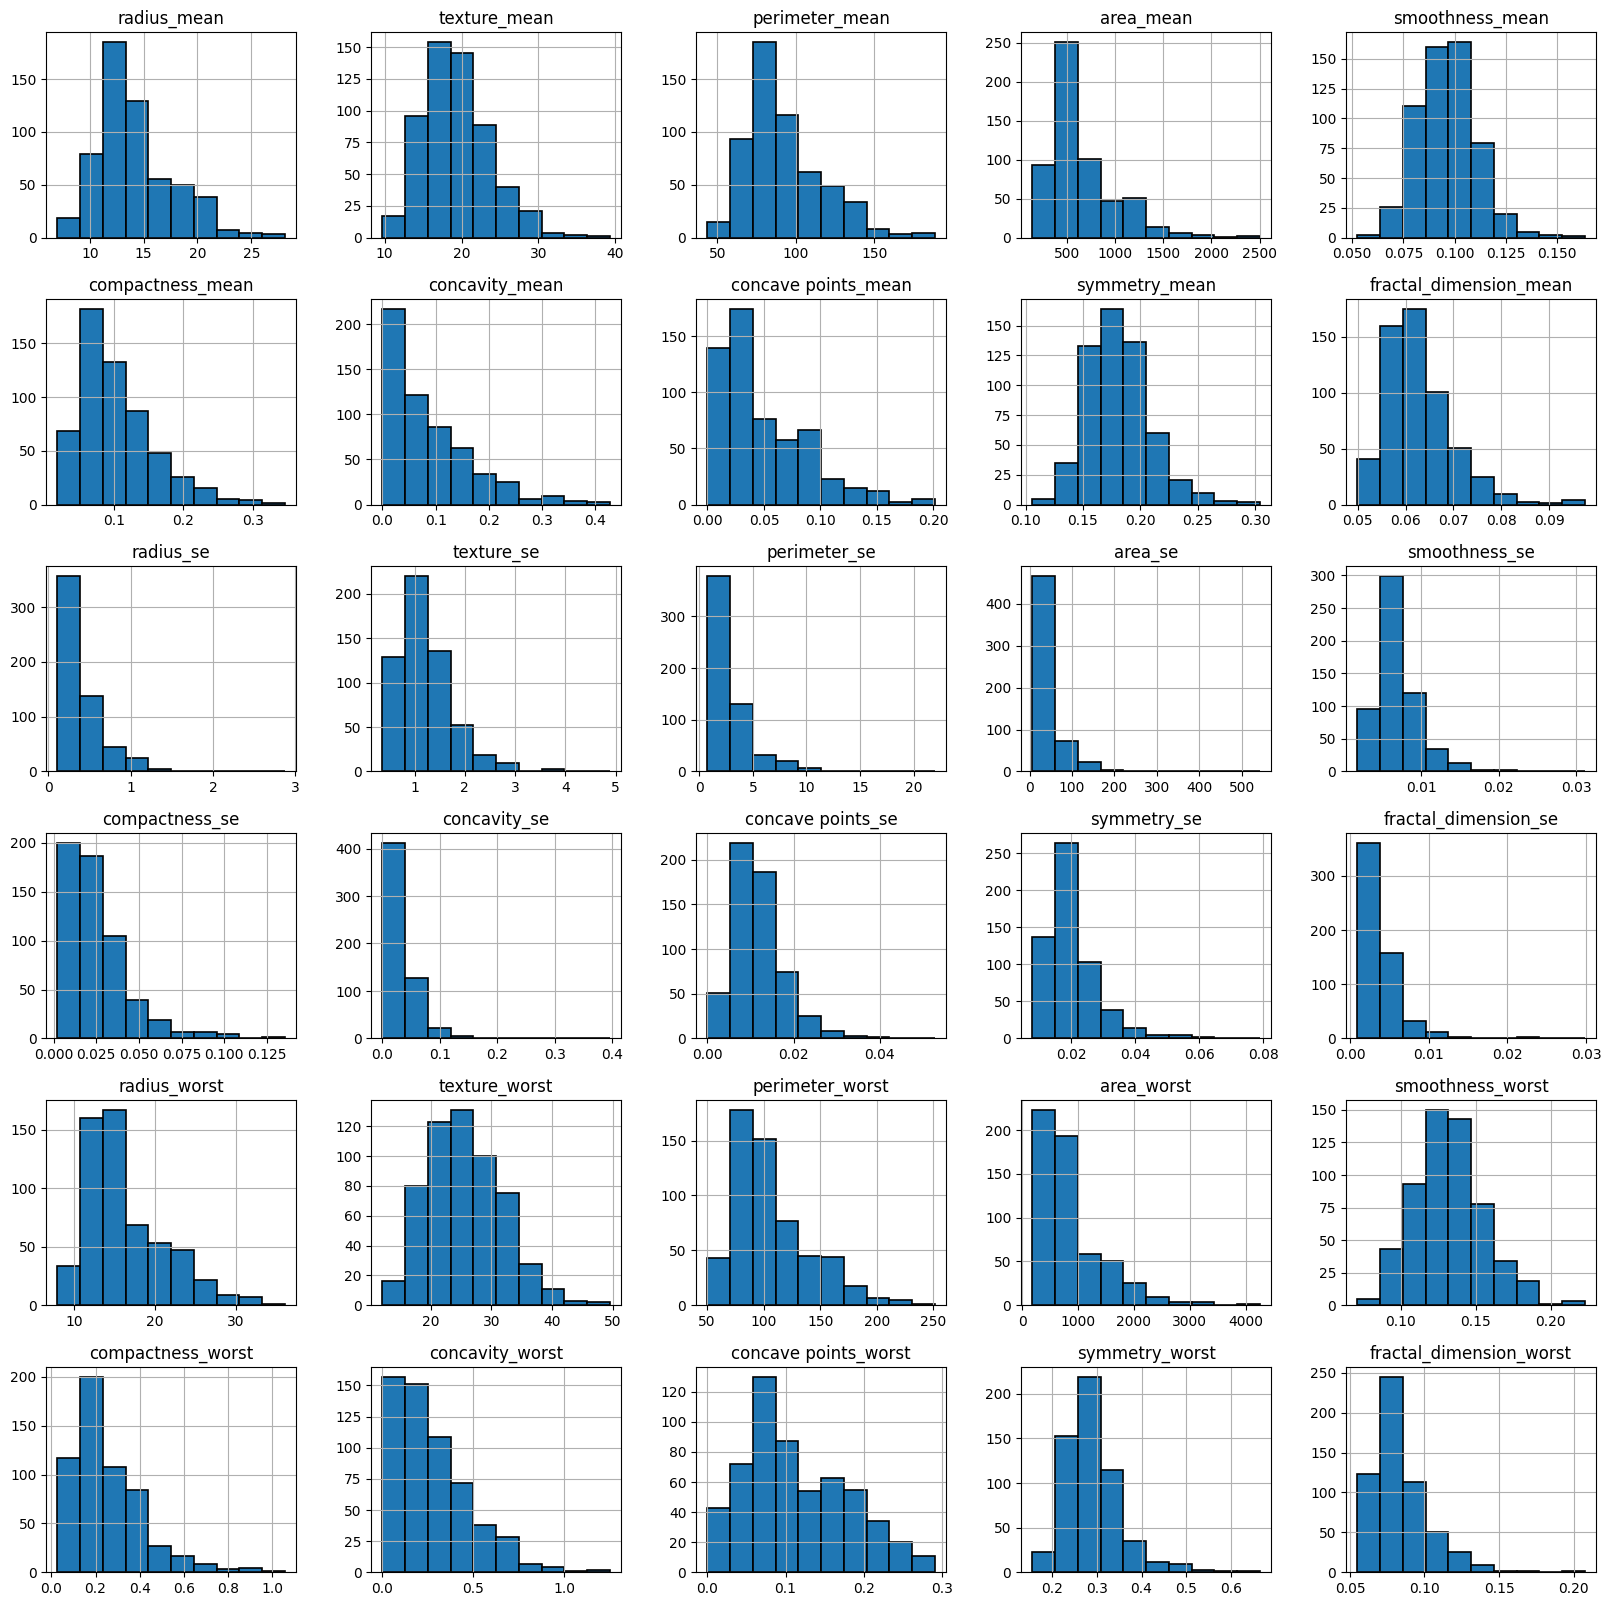

In [6]:
data.hist(edgecolor='black', linewidth=1.2, figsize=(20, 20))
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()


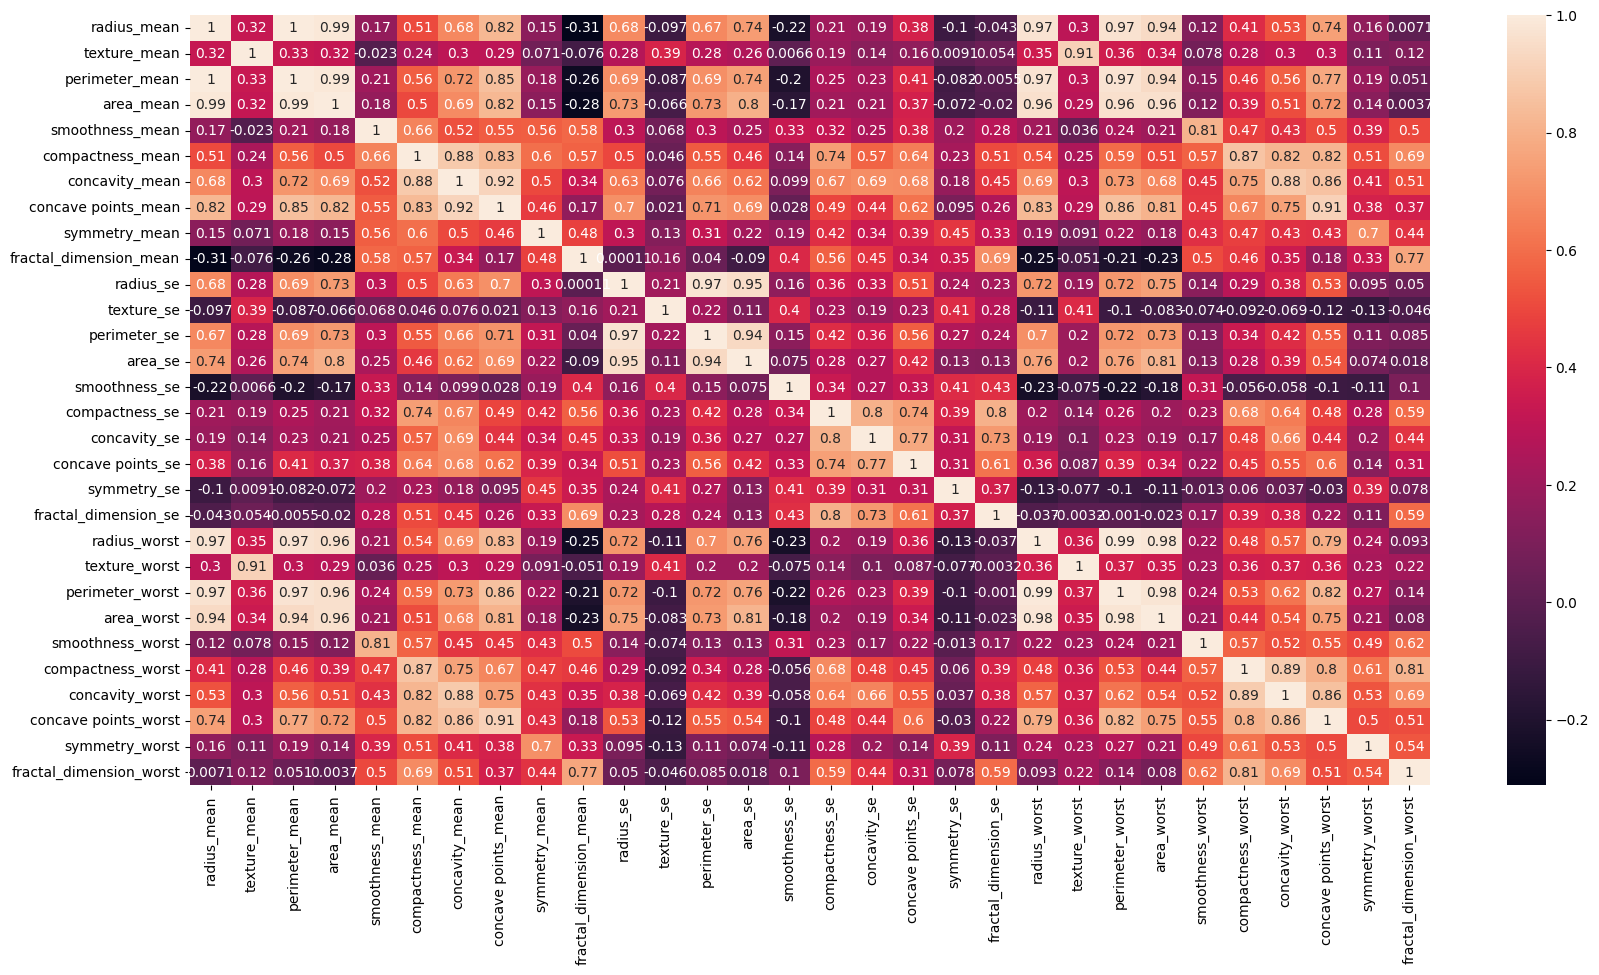

In [17]:
# How to check correction between features
plt.figure(figsize=(20,10))
new_data = data.drop('diagnosis',axis=1)
sns.heatmap(new_data.corr(),annot=True)
plt.show()


No tutaj troche ciezko cos wyczytac, pewnie mozna by sie pobawic zeby jakos te dane podzielic. Ale lecimy dalej jak bedzie extra czas to mozna sie pobawic


In [39]:
# How to automatically select the best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = data.drop('diagnosis',axis=1)
y = data['diagnosis']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print sorted all features scores
print(featureScores.nlargest(len(X.columns),'Score'))  #print 10 best features

best_10_features = featureScores.nlargest(10,'Score')
print("Best 10 features")
print(best_10_features)  #print 10 best features



                      Specs          Score
23               area_worst  112598.431564
3                 area_mean   53991.655924
13                  area_se    8758.504705
22          perimeter_worst    3665.035416
2            perimeter_mean    2011.102864
20             radius_worst     491.689157
0               radius_mean     266.104917
12             perimeter_se     250.571896
21            texture_worst     174.449400
1              texture_mean      93.897508
26          concavity_worst      39.516915
10                radius_se      34.675247
6            concavity_mean      19.712354
25        compactness_worst      19.314922
27     concave points_worst      13.485419
7       concave points_mean      10.544035
5          compactness_mean       5.403075
28           symmetry_worst       1.298861
16             concavity_se       1.044718
15           compactness_se       0.613785
24         smoothness_worst       0.397366
17        concave points_se       0.305232
8          

In [50]:
# Keep only the best features

best_columns = best_10_features['Specs'].values
best_columns.put(0, 'diagnosis')
print(best_columns)

best_data = data[best_columns]
# data.head(3)
# print()
best_data.head(3)


['diagnosis' 'area_mean' 'area_se' 'perimeter_worst' 'perimeter_mean'
 'radius_worst' 'radius_mean' 'perimeter_se' 'texture_worst'
 'texture_mean']


,diagnosis,area_mean,area_se,perimeter_worst,perimeter_mean,radius_worst,radius_mean,perimeter_se,texture_worst,texture_mean
0,M,1001.0,153.40,184.6,122.8,25.38,17.99,8.589,17.33,10.38
1,M,1326.0,74.08,158.8,132.9,24.99,20.57,3.398,23.41,17.77
2,M,1203.0,94.03,152.5,130.0,23.57,19.69,4.585,25.53,21.25


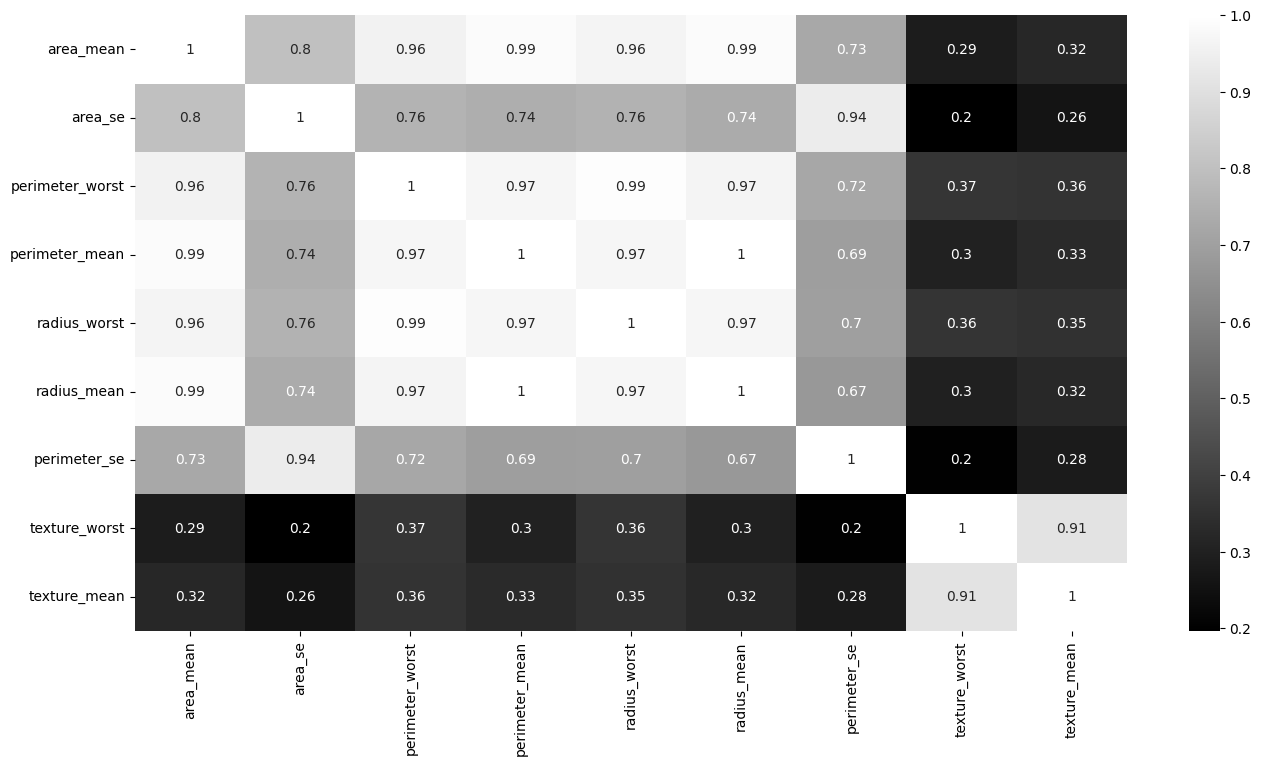

In [51]:
plt.figure(figsize=(16,8))
sns.heatmap(best_data.drop("diagnosis", axis=1).corr(),annot=True,cmap='gray')
plt.show()

Tutaj ewidentnie widzimy że dwie cechy z pozostałymi uzyskujemy najnizsza korelacje czyli w nauczeniu moglibysmy sie glownie na nich skupic jesli dobrze rozumiem 

Dzielimy sobie dane 80% uczenie / 20% testowanie

In [65]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.2)

train_X = train.drop(["diagnosis"], axis=1)
train_Y = train["diagnosis"]

test_X = test.drop(["diagnosis"], axis=1)
test_Y = test["diagnosis"]


No dobra to lecimy z modelami w tensorflow i zobaczymy jak to dziala

Najpierw musimy przerobic dane z pandas na zbiory z uzyciem tensor flow

In [31]:
train.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
429,B,12.72,17.67,80.98,501.3,0.07896,0.04522,0.01402,0.01835,0.1459,...,13.82,20.96,88.87,586.8,0.1068,0.09605,0.03469,0.03612,0.2165,0.06025
317,M,18.22,18.87,118.70,1027.0,0.09746,0.11170,0.11300,0.07950,0.1807,...,21.84,25.00,140.90,1485.0,0.1434,0.27630,0.38530,0.17760,0.2812,0.08198
44,M,13.17,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,...,16.23,29.89,105.50,740.7,0.1503,0.39040,0.37280,0.16070,0.3693,0.09618


In [56]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="diagnosis")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="diagnosis")






No dobra to tworzymy pierwszy model

In [78]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

start_1 = time.time()
model.compile(metrics=["accuracy"])
model.fit(train_ds)
end_1 = time.time()


Use /tmp/tmpnwbfddj2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.233644. Found 455 examples.
Training model...
Model trained in 0:00:00.036811
Compiling model...
Model compiled.


I0000 00:00:1724419767.314644   20057 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1724419767.314703   20057 kernel.cc:775] Collect training examples
I0000 00:00:1724419767.314711   20057 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1724419767.314795   20057 kernel.cc:394] Number of batches: 1
I0000 00:00:1724419767.314808   20057 kernel.cc:395] Number of examples: 455
I0000 00:00:1724419767.314899   20057 kernel.cc:794] Training dataset:
Number of records: 455
Number of columns: 31

Number of columns by type:
	NUMERICAL: 30 (96.7742%)
	CATEGORICAL: 1 (3.22581%)

Columns:

NUMERICAL: 30 (96.7742%)
	1: "area_mean" NUMERICAL me

No dobra model nauczony to zobaczymy jakie sa jego wyniki

In [58]:
evaluation = model.evaluate(test_ds, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 223ms/step - loss: 0.0000e+00 - accuracy: 0.9649
loss: 0.0000
accuracy: 0.9649


In [59]:
model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	area_mean
	area_se
	area_worst
	compactness_mean
	compactness_se
	compactness_worst
	concave_points_mean
	concave_points_se
	concave_points_worst
	concavity_mean
	concavity_se
	concavity_worst
	fractal_dimension_mean
	fractal_dimension_se
	fractal_dimension_worst
	perimeter_mean
	perimeter_se
	perimeter_worst
	radius_mean
	radius_se
	radius_worst
	smoothness_mean
	smoothness_se
	smoothness_worst
	symmetry_mean
	symmetry_se
	symmetry_worst
	texture_mean
	texture_se
	texture_worst

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.         "perimeter_worst"  0.262844 ###########

Spróbujmy innego modelu, 

In [79]:
start_2 = time.time()
model_2 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)
model_2.compile(metrics=["accuracy"])
model_2.fit(train_ds)
end_2 = time.time()

evaluation_2 = model.evaluate(test_ds, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


# model.summary()

Use /tmp/tmpyi7oztyp as temporary training directory
Reading training dataset...


2024-08-23 15:29:31.826549: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1816] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-08-23 15:29:31.826596: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1826] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-08-23 15:29:31.826601: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208072. Found 455 examples.
Training model...


I0000 00:00:1724419772.042401   20057 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1724419772.042444   20057 kernel.cc:775] Collect training examples
I0000 00:00:1724419772.042457   20057 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1724419772.042545   20057 kernel.cc:394] Number of batches: 1
I0000 00:00:1724419772.042549   20057 kernel.cc:395] Number of examples: 455
I0000 00:00:1724419772.042635   20057 kernel.cc:794] Training dataset:
Number of records: 455
Number of columns: 31

Number of columns by type:
	NUMERICAL: 30 (96.7742%)
	CATEGORICAL: 1 (3.22581%)

Columns:

NUMERICAL: 30 (96.7742%)
	1: "area_mean" NUMERICAL me

Model trained in 0:00:01.416590
Compiling model...
Model compiled.


2024-08-23 15:29:33.432147: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1579] 	num-trees:300 train-loss:0.000006 train-accuracy:1.000000 valid-loss:0.000166 valid-accuracy:1.000000
2024-08-23 15:29:33.432184: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1616] Create final snapshot of the model at iteration 300
2024-08-23 15:29:33.438288: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:275] Truncates the model to 300 tree(s) i.e. 300  iteration(s).
2024-08-23 15:29:33.438323: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:337] Final model num-trees:300 valid-loss:0.000166 valid-accuracy:1.000000
I0000 00:00:1724419773.439935    8866 kernel.cc:920] Export model in log directory: /tmp/tmpyi7oztyp with prefix c7d44126fe7d4e20
I0000 00:00:1724419773.443868    8866 kernel.cc:938] Sav

1/1 [==============================] - 0s 94ms/step - loss: 0.0000e+00 - accuracy: 0.9649
loss: 0.0000
accuracy: 0.9649


No dobra chyba nie ma wielkie różnicy miedzy modalami w obu dokładność jest na wysokim poziomie 

In [72]:
print("Model 1 - dokladnosc", evaluation['accuracy'])
print("Model 2 - dokladnosc", evaluation_2['accuracy'])


Model 1 - dokladnosc 0.9649122953414917
Model 2 - dokladnosc 0.9649122953414917


Spróbujmy w takim razie uzyc okrojonego modelu danych, gdzie mamy tylko 10 najlepszych cech

In [80]:
best_train, best_test = sklearn.model_selection.train_test_split(best_data, test_size=0.2)
best_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(best_train, label="diagnosis")
best_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(best_test, label="diagnosis")

start_3 = time.time()
model_3 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
model_3.compile(metrics=["accuracy"])
model_3.fit(best_train_ds)
end_3 = time.time()
evaluation_3 = model_3.evaluate(best_test_ds, return_dict=True)




Use /tmp/tmp5rgcr0qu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117086. Found 455 examples.
Training model...
Model trained in 0:00:00.037190
Compiling model...
Model compiled.
1/1 [==============================] - 0s 73ms/step - loss: 0.0000e+00 - accuracy: 0.9386


I0000 00:00:1724419782.021626   20057 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1724419782.021666   20057 kernel.cc:775] Collect training examples
I0000 00:00:1724419782.021674   20057 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1724419782.021718   20057 kernel.cc:394] Number of batches: 1
I0000 00:00:1724419782.021721   20057 kernel.cc:395] Number of examples: 455
I0000 00:00:1724419782.021749   20057 kernel.cc:794] Training dataset:
Number of records: 455
Number of columns: 10

Number of columns by type:
	NUMERICAL: 9 (90%)
	CATEGORICAL: 1 (10%)

Columns:

NUMERICAL: 9 (90%)
	1: "area_mean" NUMERICAL mean:651.66 min:143

Wyniki troche gorsze ale nadal super

In [75]:
print("Model 1 - dokladnosc", evaluation['accuracy'])
print("Model 2 - dokladnosc", evaluation_2['accuracy'])
print("Model 3 - dokladnosc", evaluation_3['accuracy'])

Model 1 - dokladnosc 0.9649122953414917
Model 2 - dokladnosc 0.9649122953414917
Model 3 - dokladnosc 0.9561403393745422


In [81]:
#how to compere models training time

print("Model 1 - czas trenowania", end_1 - start_1)
print("Model 1 - czas trenowania", end_2 - start_2)
print("Model 1 - czas trenowania", end_3 - start_3)

Model 1 - czas trenowania 0.39157986640930176
Model 1 - czas trenowania 1.7522757053375244
Model 1 - czas trenowania 0.23505711555480957


Widzimy, że juz przy tak małych teoretycznie danych przy skroconych cechach czas nauki jest prawie polowe mniejszy, a dokladnie pozostaje nadal na wysokim poziomie 